# EDA básico:
1. CONAPO.
2. Delitos.
3. Enucesta de la INEGI.

- Relacionar fecha con num delitos, con territorio, con tipo delito
- Observar los estados/ciudades con más narcotrafico y sus delitos
- Evolución de los delitos en el tiempo (por año)

In [1]:
# Importando las librerías...

# Manejar rutas
from pathlib import Path

# Cargar y transformar datos
import pandas as pd
import numpy as np
import json
import ast

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib widget
%matplotlib inline

# Manejo de valores faltantes
import missingno as msno

In [2]:
# Establecer las rutas para acceder a los datos tidy...
data_path = Path('./data')
tidy_data_path = Path(data_path / 'tidy')

# 1. CONAPO.
Se mostrarán gráficos sobre:
- Tamaños de poblaciones.
- Pirámides poblacionales.

Con el objetivo de entender la composición de las poblaciones que se van a estudiar. Y luego establecer comparaciones entre estos tamaños de población y los índices delictivos, y KPIs del trabajo.

In [3]:
# Carga del Tidy...
df_conapo = pd.read_csv(tidy_data_path / "proyecciones_conapo.csv")

In [4]:
# Analizando los Datos...
df_conapo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65340 entries, 0 to 65339
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   AÑO        65340 non-null  int64 
 1   ENTIDAD    65340 non-null  object
 2   CVE_GEO    65340 non-null  int64 
 3   EDAD       65340 non-null  int64 
 4   GRUPO      65340 non-null  object
 5   SEXO       65340 non-null  object
 6   POBLACION  65340 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 3.5+ MB


In [5]:
df_conapo

,AÑO,ENTIDAD,CVE_GEO,EDAD,GRUPO,SEXO,POBLACION
0,2015,República Mexicana,0,0,0 a 4,Hombres,1134441
1,2015,República Mexicana,0,0,0 a 4,Mujeres,1093705
2,2015,República Mexicana,0,1,0 a 4,Hombres,1138096
3,2015,República Mexicana,0,1,0 a 4,Mujeres,1097638
4,2015,República Mexicana,0,2,0 a 4,Hombres,1145745
...,...,...,...,...,...,...,...
65335,2023,Zacatecas,32,107,85 y más,Mujeres,2
65336,2023,Zacatecas,32,108,85 y más,Hombres,2
65337,2023,Zacatecas,32,108,85 y más,Mujeres,0
65338,2023,Zacatecas,32,109,85 y más,Hombres,1


In [6]:
# Crear el diccionario de entidades para homogenizar las Bases de Datos...
dict_entidades = dict(zip(df_conapo["CVE_GEO"].unique(), df_conapo["ENTIDAD"].unique()))
entidades_val = df_conapo["CVE_GEO"].unique()

# print(dict_entidades[26])
# dict_entidades

In [7]:
# Creando el listado de años...
anhos = list(df_conapo["AÑO"].unique())
anhos

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

In [8]:
df_piramides = df_conapo.copy()

grupos_etarios = list(df_piramides["GRUPO"].unique())
grupos_reverse = grupos_etarios.copy()
grupos_reverse.reverse()

df_piramides["GRUPO"] = pd.Categorical(df_piramides["GRUPO"], categories = grupos_etarios, ordered = True)

entidades = df_piramides["ENTIDAD"].unique()
entidades = list(entidades[1:33])

df_piramides = df_piramides[["AÑO", "CVE_GEO", "GRUPO", "SEXO", "POBLACION"]].groupby(by = ["AÑO", "CVE_GEO", "GRUPO", "SEXO"]).sum("POBLACION").reset_index()
df_piramides = df_piramides.pivot_table(index = ["AÑO", "CVE_GEO", "GRUPO"], columns = "SEXO", values = "POBLACION").reset_index()
df_piramides["POBLACION"] = df_piramides[["Hombres", "Mujeres"]].sum(axis = 1)
df_piramides.columns = ["AÑO",	"CVE_GEO",	"GRUPO",	"HOMBRES",	"MUJERES",	"POBLACION"]
# df_piramides.head(20)
df_piramides

,AÑO,CVE_GEO,GRUPO,HOMBRES,MUJERES,POBLACION
0,2015,0,0 a 4,5748190,5543337,11291527
1,2015,0,5 a 9,5837521,5655389,11492910
2,2015,0,10 a 14,5820057,5692796,11512853
3,2015,0,15 a 19,5772464,5660128,11432592
4,2015,0,20 a 24,5634166,5595657,11229823
...,...,...,...,...,...,...
5341,2023,32,65 a 69,21593,23425,45018
5342,2023,32,70 a 74,16027,17314,33341
5343,2023,32,75 a 79,12375,13406,25781
5344,2023,32,80 a 84,8377,9176,17553


In [9]:
# Función para convertir el DataFrame anterior "pob_subset" en un diccionario que se almacenará en un string...
def pob_to_dict(anho, entidad, df_de_grupos_para_piramides):
    df_pob_select = df_de_grupos_para_piramides[(df_de_grupos_para_piramides["AÑO"] == anho) & (df_de_grupos_para_piramides["CVE_GEO"] == entidad)][["GRUPO", "HOMBRES", "MUJERES"]]

    pob_dict = dict({"HOMBRES" : list(df_pob_select["HOMBRES"]),
                    "MUJERES" : list(df_pob_select["MUJERES"]),
                    "GRUPO" : list(grupos_etarios),})
    return pob_dict

# Función para extraer nuevamente los datos del diccionario a un DataFrame ...
def dict_to_pob(celda):
    pob_df = pd.DataFrame.from_dict(dict(celda.iloc[0]))
    # celda_piramide = ast.literal_eval(celda_piramide) # Usar esta línra para convertir a diccionario, como alternativa...
    return pob_df

# Función para calcular la diferencia acumulada de las proporciones de los grupos de edades de la pirámide...
def cum_diff_piramide(celda):
    df_para_clasif = pd.DataFrame.from_dict(dict(celda))

    # Calcular la proporción de población en cada grupo de edad
    df_para_clasif['POBLACION'] = df_para_clasif[["HOMBRES", "MUJERES"]].sum(axis = 1)
    df_para_clasif = df_para_clasif[["GRUPO", "HOMBRES", "MUJERES", "POBLACION"]]
    
    df_para_clasif['Proporcion'] = df_para_clasif['POBLACION'] / df_para_clasif['POBLACION'].sum()

    # Calcular la diferencia acumulativa de proporciones para determinar la forma de la pirámide
    df_para_clasif['Diferencia'] = 0
    for i in range(len(df_para_clasif) - 1):
        if i!= len(df_para_clasif) - 1:
            df_para_clasif.at[i, "Diferencia"] = df_para_clasif.at[i, 'Proporcion'] - df_para_clasif.at[i + 1, 'Proporcion']
        else:
            df_para_clasif.at[i, "Diferencia"] = 0
    diff = round(df_para_clasif['Diferencia'].sum(),6)
    return diff

In [10]:
# Crear nuevo Df tidy... donde cada registro acumulará todos los valores de población de una entidad para un año determinado...
pob_lista_tidy = df_piramides.groupby(["AÑO", "CVE_GEO"]).sum(["HOMBRES",	"MUJERES",	"POBLACION"]).reset_index()

# Creando columna Pirámide...
pob_lista_tidy["PIRAMIDE"] = None
pob_lista_tidy["PIRAMIDE"] = pob_lista_tidy.apply(lambda row: pob_to_dict(row['AÑO'], row['CVE_GEO'], df_piramides), axis=1)

# Volviendo a crear la columna con nombres de Entidades...
pob_lista_tidy["ENTIDAD"] = pob_lista_tidy["CVE_GEO"].map(dict_entidades)

pob_lista_tidy["CUM_DIFF"] = 0
pob_lista_tidy["CUM_DIFF"] = pob_lista_tidy["PIRAMIDE"].apply(cum_diff_piramide)

pob_lista_tidy.head()

pob_lista_tidy = pob_lista_tidy[["AÑO",	"CVE_GEO", "ENTIDAD", "HOMBRES", "MUJERES", "POBLACION", "PIRAMIDE", "CUM_DIFF"]]

pob_lista_tidy

,AÑO,CVE_GEO,ENTIDAD,HOMBRES,MUJERES,POBLACION,PIRAMIDE,CUM_DIFF
0,2015,0,República Mexicana,59579638,62155178,121734816,"{'HOMBRES': [5748190, 5837521, 5820057, 577246...",0.086343
1,2015,1,Aguascalientes,654661,678329,1332990,"{'HOMBRES': [68053, 68220, 68545, 68714, 65678...",0.094859
2,2015,2,Baja California,1688929,1677852,3366781,"{'HOMBRES': [146954, 158024, 160305, 162490, 1...",0.082247
3,2015,3,Baja California Sur,367806,354293,722099,"{'HOMBRES': [32587, 33681, 32869, 33769, 35513...",0.085290
4,2015,4,Campeche,451503,461588,913091,"{'HOMBRES': [43809, 43150, 41871, 42649, 44018...",0.088083
...,...,...,...,...,...,...,...,...
292,2023,28,Tamaulipas,1814258,1855051,3669309,"{'HOMBRES': [138821, 150526, 160585, 159142, 1...",0.065898
293,2023,29,Tlaxcala,679986,724044,1404030,"{'HOMBRES': [62662, 61496, 64251, 64222, 63640...",0.080140
294,2023,30,Veracruz,3910882,4222072,8132954,"{'HOMBRES': [293411, 326811, 358289, 348948, 3...",0.060505
295,2023,31,Yucatán,1199755,1236880,2436635,"{'HOMBRES': [90813, 97544, 101797, 102568, 107...",0.064941


In [11]:
# Archivo Tidy Final de Proyecciones de la CONAPO...
pob_lista_tidy.to_csv(tidy_data_path / "tidy_final_conapo.csv",  index = False)

In [12]:
# Ver población de México por Años...
def df_pob_anhos_entidad(filtro_anho, entidad):
    df_pob = dict_to_pob(pob_lista_tidy.loc[(pob_lista_tidy["AÑO"] == filtro_anho) & (pob_lista_tidy["CVE_GEO"] == entidad), "PIRAMIDE"])
    df_pob["POBLACION"] = df_pob[["HOMBRES", "MUJERES"]].sum(axis = 1)
    df_pob = df_pob[["GRUPO", "HOMBRES", "MUJERES", "POBLACION"]]

    return df_pob

widgets.interact(df_pob_anhos_entidad, filtro_anho = anhos, entidad = entidades_val);

interactive(children=(Dropdown(description='filtro_anho', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

In [13]:
# Ver poblaciones de México por Años...
def df_pob_por_anhos(filtro_anho):
    # df_pob = pob_lista_tidy.loc[(pob_lista_tidy["AÑO"] == filtro_anho), ["CVE_GEO", "ENTIDAD", "POBLACION"]].reset_index(drop = True)
    df_pob = pob_lista_tidy.loc[(pob_lista_tidy["AÑO"] == filtro_anho) & (pob_lista_tidy["CVE_GEO"] != 0), ["CVE_GEO", "ENTIDAD", "POBLACION"]].reset_index(drop = True)
    return df_pob.sort_values("POBLACION", ascending = False).reset_index(drop = True)

widgets.interact(df_pob_por_anhos, filtro_anho = anhos)

interactive(children=(Dropdown(description='filtro_anho', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

<function __main__.df_pob_por_anhos(filtro_anho)>

In [14]:
# Crear el gráfico de columnas horizontales
def graf_pob_por_anhos(filtro_anho):
    plt.figure(figsize=(8, 10))
    sns.barplot(x='POBLACION', y='ENTIDAD', data = df_pob_por_anhos(filtro_anho), palette='viridis')

    # Ajustar etiquetas y título
    plt.xlabel('Población (Millones de habitantes)')
    plt.ylabel('Entidades Federativas')
    plt.title(f'Población según Entidades. Año: {filtro_anho}')

    # Mostrar el gráfico
    plt.show()

widgets.interact(graf_pob_por_anhos, filtro_anho = anhos);

interactive(children=(Dropdown(description='filtro_anho', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

In [15]:
# Población de México en el 2023...
df_pob_mex_2023 = df_pob_anhos_entidad(2023,0)
df_pob_mex_2023

,GRUPO,HOMBRES,MUJERES,POBLACION
0,0 a 4,5302794,5111446,10414240
1,5 a 9,5480803,5281378,10762181
2,10 a 14,5755183,5548855,11304038
3,15 a 19,5699745,5565159,11264904
4,20 a 24,5656809,5589713,11246522
5,25 a 29,5456502,5462331,10918833
6,30 a 34,5128604,5269345,10397949
7,35 a 39,4461141,4853878,9315019
8,40 a 44,3794214,4452137,8246351
9,45 a 49,3639280,4239229,7878509


In [16]:
pob_lista_tidy

,AÑO,CVE_GEO,ENTIDAD,HOMBRES,MUJERES,POBLACION,PIRAMIDE,CUM_DIFF
0,2015,0,República Mexicana,59579638,62155178,121734816,"{'HOMBRES': [5748190, 5837521, 5820057, 577246...",0.086343
1,2015,1,Aguascalientes,654661,678329,1332990,"{'HOMBRES': [68053, 68220, 68545, 68714, 65678...",0.094859
2,2015,2,Baja California,1688929,1677852,3366781,"{'HOMBRES': [146954, 158024, 160305, 162490, 1...",0.082247
3,2015,3,Baja California Sur,367806,354293,722099,"{'HOMBRES': [32587, 33681, 32869, 33769, 35513...",0.085290
4,2015,4,Campeche,451503,461588,913091,"{'HOMBRES': [43809, 43150, 41871, 42649, 44018...",0.088083
...,...,...,...,...,...,...,...,...
292,2023,28,Tamaulipas,1814258,1855051,3669309,"{'HOMBRES': [138821, 150526, 160585, 159142, 1...",0.065898
293,2023,29,Tlaxcala,679986,724044,1404030,"{'HOMBRES': [62662, 61496, 64251, 64222, 63640...",0.080140
294,2023,30,Veracruz,3910882,4222072,8132954,"{'HOMBRES': [293411, 326811, 358289, 348948, 3...",0.060505
295,2023,31,Yucatán,1199755,1236880,2436635,"{'HOMBRES': [90813, 97544, 101797, 102568, 107...",0.064941


In [17]:
# Para Pirámide poblacional... crear escalas...
def crear_escala(max_pob):
    """
    Para crear ticks vals y labels para las escalas según tamaño de la población...
    """
    max_pob = (max_pob // 4) * 5
    step_exacto = max_pob // 4
    pow = len(str(step_exacto)) - 1
    
    step_round = (step_exacto // 10**pow) * 10 ** pow
    
    vals = list(set(list(np.arange(0,max_pob,step_round))) | set(list(np.arange(0,max_pob,step_round)*(-1))))
    vals.sort()
    
    if max(vals) // 1000 > 1000:
        labels = [str(abs(label // 1000000)) + "M" for label in vals]
    else:
        labels = [str(abs(label // 1000)) + "K" for label in vals]
    return vals, labels

In [18]:
# Pirámide de toda la "República Mexicana"...
def graf_piramide_por_anhos(filtro_anho, entidad):
    data_mex =df_pob_anhos_entidad(filtro_anho,entidad).copy()
    
    max_pob = data_mex[["HOMBRES", "MUJERES"]].max().max()

    data_mex["MUJERES"] *= -1

    ticks, labels = crear_escala(max_pob)

    # Crear el Gráfico...
    fig, ax = plt.subplots(figsize=(8, 7))
    bar_plot = sns.barplot(x='HOMBRES', y='GRUPO', data=data_mex, order=grupos_reverse, orient='h', palette='OrRd')
    bar_plot = sns.barplot(x='MUJERES', y='GRUPO', data=data_mex, order=grupos_reverse, orient='h', palette='PuBu', lw=0)
    bar_plot.set(title=f'Pirámide Poblacional {dict_entidades[entidad]} - Año {filtro_anho}',
                xlabel="Población (miles)",
                ylabel="Grupos de edades",
                xticks=ticks,
                xticklabels=labels)

    plt.show()

widgets.interact(graf_piramide_por_anhos, filtro_anho = anhos, entidad = entidades_val);

interactive(children=(Dropdown(description='filtro_anho', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

En la misma se puede notar que se trata de una población en fase de envejecimiento. Esta precisamente es la forma más común en todo México.

In [19]:
# Graficando desde el Tidy de Poblaciones listas... Que lee la pirámide de un diccionario...
# Graficando la pirámide poblacional de cada entidad Federativa...
def grafica_todas_por_anho(filtro_anho):
    fig, axes = plt.subplots(8, 4, figsize=(20, 45), sharey=True)

    for i, entidad in enumerate(entidades):
        df_pob_graf = df_pob_anhos_entidad(filtro_anho,i+1).copy()
        
        max_pob = df_pob_graf[["HOMBRES", "MUJERES"]].max().max()
        ticks, labels = crear_escala(max_pob)
        
        df_pob_graf["MUJERES"] *= -1

        # Crear el Gráfico...
        bar_plot = sns.barplot(x='HOMBRES', y='GRUPO', data=df_pob_graf, order=grupos_reverse, orient='h', ax=axes[(i//4),(i - (4 * (i//4)))], palette='OrRd')
        bar_plot = sns.barplot(x='MUJERES', y='GRUPO', data=df_pob_graf, order=grupos_reverse, orient='h', ax=axes[(i//4),(i - (4 * (i//4)))], palette='PuBu', lw=0)
        bar_plot.set(title=entidad,
                    xlabel="Población (miles)",
                    ylabel="Grupos de edades",
                    xticks = ticks,
                    xticklabels = labels)

    plt.show()

widgets.interact(grafica_todas_por_anho, filtro_anho = anhos);


interactive(children=(Dropdown(description='filtro_anho', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

Estados como Chiapas y Zacatecas muestras un crecimiento rápido. Otros como Durando, Guerrero, Michoacán, Oaxaca, Puebla, Tlaxcala muestran un crecimiento demográfico más lento, mientras que el resto de los estados se encuentran en fase de envejecimiento para el presente 2023.
Pudieran aparecer relaciones entre los altos índices de inseguridad y la fase o etapa demográfica.

# 2. Semáforo delictivo.

Contar los delitos por modalidad y representarlos graficamente en por cientos.

Describir un poco la muestra.

In [20]:
# Carga del Tidy...
df_delitos = pd.read_csv(tidy_data_path / "delitos_semaforo.csv", encoding = 'iso-8859-1')
# df_delitos.info()

In [21]:
df_delitos

,anio,clave_ent,entidad,clave_municipio,municipio,bien_afectado,tipo_delito,subtipo_delito,delito_semaforo,modalidad,...,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre,total
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,Con arma de fuego,...,1,0,1,1,0,2,1,0,1,9
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,Con arma blanca,...,0,0,1,0,1,0,0,0,0,3
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,Con otro elemento,...,1,3,2,0,1,2,0,0,0,9
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,No especificado,...,1,0,0,0,0,0,0,0,0,2
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Lesiones,Lesiones dolosas,Lesiones,Con arma de fuego,...,1,1,1,3,2,1,3,2,2,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656606,2023,32,Zacatecas,32058,Santa María de la Paz,El patrimonio,Robo,Robo a negocio,Robo a negocio,Con violencia,...,0,0,0,0,0,0,0,0,0,0
656607,2023,32,Zacatecas,32058,Santa María de la Paz,El patrimonio,Robo,Robo a negocio,Robo a negocio,Sin violencia,...,0,0,0,0,0,0,0,0,0,0
656608,2023,32,Zacatecas,32058,Santa María de la Paz,El patrimonio,Extorsión,Extorsión,Extorsión,Extorsión,...,0,0,0,0,0,0,0,0,0,0
656609,2023,32,Zacatecas,32058,Santa María de la Paz,La familia,Violencia familiar,Violencia familiar,Violencia familiar,Violencia familiar,...,1,0,0,0,0,0,0,0,0,1


In [22]:
# Inicializando los diccionarios de delitos...

diccionario_delitos = {
    "Homicidio doloso" : "Homicidios" ,
    #"Homicidio culposo" : "Homicidios" ,
    "Lesiones dolosas" : "Lesiones" ,
    #"Lesiones culposas" : "Lesiones" ,
    "Feminicidio" : "Feminicidio" ,
    "Secuestro" : "Secuestros" ,
    "Violación simple" : "Violación" ,
    #"Violación equiparada" : "Violación" ,
    "Robo a casa habitación" : "Robo a casa" ,
    "Robo de vehículo automotor" : "Robo a vehículo" ,
    "Robo a negocio" : "Robo a negocio" ,
    "Extorsión" : "Extorsión" ,
    "Violencia familiar" : "Violencia familiar" ,
    "Narcomenudeo" : "Narcomenudeo" ,
}

tasas = {
    "Feminicidio":0,
    "Homicidios":0,
    "Secuestros":0,
    "Robo a casa":0,
    "Robo a vehículo":0,
    "Robo a negocio":0,
    "Violación":0,
    "Narcomenudeo":0,
    "Extorsión":0,
    "Violencia familiar":0,
    "Lesiones":0 ,
    }

lista_delitos = list(diccionario_delitos.values())

In [23]:
df_delitos_tidy = df_delitos.copy()

In [24]:
# Este set de datos no trae los delitos de Todo México ya resumidos, hay que crearlos...
# Esta función lo hace...
def agregar_rep_mex(df_set):
    for anho in anhos:
        # Seleccionamos las filas, y columnas a sumar... para valcular el total...
        sumar_entidades = df_set.loc[df_set["anio"] == anho, lista_delitos]

        # Calcula la suma de las filas seleccionadas
        suma_filas = sumar_entidades.sum()

        # Agregar a la lista de Columnas que se van a incluir: el "año" y la "clave_ent"...
        columnas = list(sumar_entidades.columns)
        columnas[0:0] = ["anio", "clave_ent"]

        # Agregar a los valores que se van a calcular: el año y el 0 que identifica a la República de México...
        valores = list(suma_filas.values)
        valores[0:0] = [anho, 0]

        # Crea un nuevo DataFrame con la fila de la suma
        df_fila_totales = pd.DataFrame([valores], columns=columnas)

        # Concatena el nuevo DataFrame con el original
        df_set = pd.concat([df_set, df_fila_totales], ignore_index=True)
    return df_set

In [25]:
df_delitos_tidy = df_delitos.copy()
df_delitos_tidy = df_delitos_tidy[["anio", "clave_ent", "delito_semaforo", "total"]].groupby(["anio", "clave_ent", "delito_semaforo"]).sum().reset_index()
df_delitos_tidy = df_delitos_tidy.pivot_table(index = ["anio", "clave_ent"], columns = ["delito_semaforo"], values = "total").reset_index()

# Agregar la Entidad 0 a delitos Tidy...
df_delitos_tidy = agregar_rep_mex(df_delitos_tidy)

df_delitos_tidy["TOTAL_DELITOS"] = df_delitos_tidy[lista_delitos].sum(axis = 1)
df_delitos_tidy = df_delitos_tidy.sort_values(["anio", "clave_ent"]).reset_index(drop = True)
#df_delitos_tidy[(df_delitos_tidy["anio"] == 2015) & (df_delitos_tidy["clave_ent"] == 0)]
df_delitos_tidy["DELITOS"] = df_delitos_tidy[lista_delitos].to_dict(orient='records')
df_delitos_tidy = df_delitos_tidy[["anio", "clave_ent", "DELITOS", "TOTAL_DELITOS"]]
df_delitos_tidy.columns = ["AÑO", "CVE_GEO", "DELITOS", "TOTAL_DELITOS"]
df_delitos_tidy

,AÑO,CVE_GEO,DELITOS,TOTAL_DELITOS
0,2015,0,"{'Homicidios': 13666, 'Lesiones': 119595, 'Fem...",562971
1,2015,1,"{'Homicidios': 33, 'Lesiones': 1890, 'Feminici...",8001
2,2015,2,"{'Homicidios': 709, 'Lesiones': 9820, 'Feminic...",46402
3,2015,3,"{'Homicidios': 136, 'Lesiones': 1095, 'Feminic...",6337
4,2015,4,"{'Homicidios': 37, 'Lesiones': 86, 'Feminicidi...",705
...,...,...,...,...
292,2023,28,"{'Homicidios': 231, 'Lesiones': 1412, 'Feminic...",10913
293,2023,29,"{'Homicidios': 60, 'Lesiones': 47, 'Feminicidi...",1699
294,2023,30,"{'Homicidios': 526, 'Lesiones': 4282, 'Feminic...",21413
295,2023,31,"{'Homicidios': 23, 'Lesiones': 104, 'Feminicid...",636


In [26]:
# Archivo Tidy Final de Delitos...
df_delitos_tidy.to_csv(tidy_data_path / "tidy_final_delitos.csv", index = False)

In [27]:
def df_delitos_por_anhos(anio):
    delitos_anho = df_delitos_tidy.loc[df_delitos_tidy["AÑO"] == anio,
                                ["AÑO", "CVE_GEO", "TOTAL_DELITOS"]]#.groupby(["anio","entidad", "clave_ent"]).sum())
    return delitos_anho.reset_index(drop=True)

widgets.interact(df_delitos_por_anhos, anio = anhos);
df_delitos_por_anhos(2023);

interactive(children=(Dropdown(description='anio', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 20…

In [28]:
df_pob_anho = df_pob_por_anhos(2023)
df_pob_anho

,CVE_GEO,ENTIDAD,POBLACION
0,15,México,17441998
1,9,Ciudad de México,9229871
2,14,Jalisco,8692181
3,30,Veracruz,8132954
4,21,Puebla,6866167
5,11,Guanajuato,6392255
6,19,Nuevo León,6148962
7,7,Chiapas,5904967
8,16,Michoacán,4926226
9,20,Oaxaca,4260710


In [29]:
df_tasas_delitos_anho = df_delitos_por_anhos(2023)
df_tasas_delitos_anho

,AÑO,CVE_GEO,TOTAL_DELITOS
0,2023,0,513589
1,2023,1,9000
2,2023,2,31506
3,2023,3,4849
4,2023,4,5303
5,2023,5,17137
6,2023,6,6726
7,2023,7,2837
8,2023,8,20462
9,2023,9,42281


In [30]:
df_pob_por_anhos(2023)

,CVE_GEO,ENTIDAD,POBLACION
0,15,México,17441998
1,9,Ciudad de México,9229871
2,14,Jalisco,8692181
3,30,Veracruz,8132954
4,21,Puebla,6866167
5,11,Guanajuato,6392255
6,19,Nuevo León,6148962
7,7,Chiapas,5904967
8,16,Michoacán,4926226
9,20,Oaxaca,4260710


In [31]:
# Delitos y sus tasas en un Año y Entidad específica...
import math

def df_tasas_delitos(filtro_anio): 
    df_tasas_delitos_anho = df_delitos_por_anhos(filtro_anio)
    df_pob_anho = df_pob_por_anhos(filtro_anio)

    for entidad in range(1,33):
                hechos = df_tasas_delitos_anho[df_tasas_delitos_anho["CVE_GEO"] == entidad]["TOTAL_DELITOS"]
                poblacion = df_pob_anho["POBLACION"][df_pob_anho["CVE_GEO"]==entidad]
                
                poblacion = poblacion.reset_index(drop = True)
                poblacion = poblacion.iloc[0]

                tasa = round(((hechos / poblacion) * 100000),1)

                df_tasas_delitos_anho.loc[df_tasas_delitos_anho["CVE_GEO"] == entidad, "TASA_DELICTIVA"] = tasa
    return df_tasas_delitos_anho.sort_values("TASA_DELICTIVA", ascending = False)

widgets.interact(df_tasas_delitos, filtro_anio = anhos);


interactive(children=(Dropdown(description='filtro_anio', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

In [32]:
# Resumir en un gráfico de columnas horizontales...
def graf_tasas_delitos(filtro_anho):
    plt.figure(figsize=(8, 10))

    df_graficar = df_tasas_delitos(filtro_anho)
    df_graficar["ENTIDAD"] = df_graficar["CVE_GEO"].map(dict_entidades)

    sns.barplot(x='TASA_DELICTIVA', y='ENTIDAD', data = df_graficar, palette='viridis')

    # Ajustar etiquetas y título...
    plt.xlabel('Tasa delictiva por cada 100 000 habitantes')
    plt.ylabel('Entidades Federativas')
    plt.title(f'Tasas de delitos del semáforo. Año: {filtro_anho}')

    # Mostrar el gráfico
    plt.show()

widgets.interact(graf_tasas_delitos, filtro_anho = anhos)

interactive(children=(Dropdown(description='filtro_anho', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

<function __main__.graf_tasas_delitos(filtro_anho)>

Para el 2023 se obtuvieron semejanzas en cuanto al resultado del análisis gráfico de las pirámides. Estados como Chiapas y Zacatecas, que exhiben un crecimiento poblacional más rápido tienen menores tasas delictivas. De la misma forma se esperaba que estados como Durando, Guerrero, Michoacán, Oaxaca, Puebla, Tlaxcala tampoco presentaran tasas delictivas elevadas, sino bajas como fue el caso. Sería interesante elaborar un KPI que pudiera englobar el análisis de estos componentes, pero para ello habría que obtener datos de otra fuente, donde se registren las edades de los victimarios. Una de las hipósetis que se pudiera plantear es la relación entre tasas delictivas elevadas y poblaciones en fase de envejecimiento o transición demográfica.

# 3. INEGI. Encuesta de percepción de inseguridad.

Lo básico...

In [33]:
# Carga del Tidy...
df_inegi = pd.read_csv(tidy_data_path / "percepcion_inseguridad_inegi.csv").reset_index()
# Redondear valores...
df_inegi.iloc[:, 2:15] = round(df_inegi.iloc[: , 2:15],1)

Para concluis apenas vamos a graficar la percepción deinseguridad según encuesta del INEGI.

In [34]:
df_inegi2 = df_inegi[["index", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"]].reset_index(drop = True)
df_inegi2.columns = ["CVE_GEO", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"]
df_inegi2 = pd.melt(df_inegi2, id_vars = "CVE_GEO", var_name = "AÑO",
                    value_name = "PERCEPCION", value_vars=["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"])
df_inegi2 = df_inegi2[["AÑO", "CVE_GEO", "PERCEPCION"]]
df_inegi2

# Archivo Tidy Final de Percepción de Inseguridad INEGI...
df_inegi2.to_csv(tidy_data_path / "tidy_final_inegi.csv", index = False)

In [35]:
df_inegi

,index,Entidad,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,0,Estados Unidos Mexicanos,69.5,66.6,72.3,73.3,73.2,72.4,72.4,79.4,78.9,78.6,75.6,75.9,74.6
1,1,Aguascalientes,60.8,46.5,51.8,49.1,43.2,42.5,42.5,60.9,56.4,54.6,51.5,54.2,49.7
2,2,Baja California,58.2,51.6,51.5,53.7,53.2,56.8,56.8,72.7,66.4,64.2,68.1,76.1,68.5
3,3,Baja California Sur,37.1,24.4,30.1,39.3,61.8,44.2,44.2,65.3,48.2,35.7,34.3,34.9,33.4
4,4,Campeche,51.2,44.6,56.7,58.9,53.7,54.4,54.4,57.8,61.0,56.1,53.2,54.1,61.6
5,5,Coahuila de Zaragoza,64.6,74.6,82.0,78.5,74.9,55.9,55.9,64.0,57.1,53.0,53.4,50.4,44.1
6,6,Colima,65.8,70.8,71.1,56.9,56.5,72.0,72.0,80.5,77.8,73.3,72.5,85.8,80.9
7,7,Chiapas,38.3,37.9,51.0,62.1,54.6,57.2,57.2,71.4,68.8,67.0,66.7,72.6,68.1
8,8,Chihuahua,89.5,82.7,78.0,75.2,73.6,63.1,63.1,80.9,80.8,75.7,73.6,71.6,78.1
9,9,Distrito Federal,75.3,70.8,73.0,77.6,78.5,84.6,84.6,88.3,89.2,85.8,85.3,83.2,80.1


In [36]:
# Resultados de encuesta por años...
def df_inegi_anhos(filtro_anio):
    return df_inegi.loc[1:32,["index", "Entidad",str(filtro_anio)]].sort_values(str(filtro_anio), ascending = False)

def graf_percepcion_inegi(filtro_anio): 
    percepcion_inegi_anho = df_inegi_anhos(filtro_anio)

    plt.figure(figsize=(8, 10))
    
    sns.barplot(x=str(filtro_anio), y='Entidad', data = percepcion_inegi_anho, palette='viridis')

    # Ajustar etiquetas y título
    plt.xlabel('Percepción de inseguridad en mayores de 18 años. (%)')
    plt.ylabel('Entidades Federativas')
    plt.title(f'Percepción de inseguridad según Entidades. Año: {filtro_anio}')

    # Mostrar el gráfico
    plt.show()

widgets.interact(graf_percepcion_inegi, filtro_anio = range(2015,2024))

interactive(children=(Dropdown(description='filtro_anio', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

<function __main__.graf_percepcion_inegi(filtro_anio)>

In [37]:
# Concatenar los Data Frames...
def df_concatenar(filtro_anio):
    df_final = pd.merge(df_inegi_anhos(filtro_anio), df_tasas_delitos(filtro_anio), left_on="index", right_on="CVE_GEO", how="inner")
    df_final = df_final[["CVE_GEO", "Entidad", str(filtro_anio),"TASA_DELICTIVA"]]
    df_final.columns = ["CVE_GEO", "Entidad", "Inseguridad","TASA_DELICTIVA"]
    return df_final

df_concatenar(2023)

,CVE_GEO,Entidad,Inseguridad,TASA_DELICTIVA
0,32,Zacatecas,91.9,330.8
1,15,México,88.0,503.6
2,17,Morelos,87.0,521.3
3,11,Guanajuato,82.9,586.6
4,30,Veracruz de Ignacio de la Llave,81.4,263.3
5,6,Colima,80.9,891.0
6,16,Michoacán de Ocampo,80.8,237.9
7,9,Distrito Federal,80.1,458.1
8,14,Jalisco,78.7,334.2
9,21,Puebla,78.3,286.4


In [38]:
# Comparación entre tasa acumulada anual de los delitos del Semáforo Delictivo y la encuesta de inseguridad del INEGI.
# Resultados de encuesta por años...

def graf_comparativa(filtro_anio):
    df_concatenado = df_concatenar(filtro_anio).sort_values("TASA_DELICTIVA", ascending=False)

    # Crear una figura con dos subgráficos
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # Graficar en el primer subgráfico
    sns.barplot(x='TASA_DELICTIVA', y='Entidad', data=df_concatenado, color="blue", ax=axes[0])
    axes[0].set_xlabel('Tasa delictiva (por 100,000 habitantes)')
    axes[0].set_ylabel('Entidades Federativas')
    axes[0].set_title('Tasa delictiva del Semáforo Delictivo')

    # Graficar en el segundo subgráfico
    sns.barplot(x='Inseguridad', y='Entidad', data=df_concatenado, color="red", ax=axes[1])
    axes[1].set_xlabel('Percepción de inseguridad (%)')
    axes[1].set_ylabel('Entidades Federativas')
    axes[1].set_title('Percepción de inseguridad del INEGI')

    # Ajustar el diseño de la figura
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

widgets.interact(graf_comparativa, filtro_anio=range(2015, 2024))

interactive(children=(Dropdown(description='filtro_anio', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

<function __main__.graf_comparativa(filtro_anio)>

# Merge de Archivos Tidys... versión Final...

In [39]:
# Agregar las áreas...
# Agregar las pirámides... en una línea...
# Crear el Dashboard...

In [40]:
df_final_conapo = pd.read_csv(tidy_data_path / "tidy_final_conapo.csv")
df_final_delitos = pd.read_csv(tidy_data_path / "tidy_final_delitos.csv")
df_final_inegi = pd.read_csv(tidy_data_path / "tidy_final_inegi.csv")

In [41]:
# DataFrame final de CONAPO...
print(df_final_conapo.shape)
df_final_conapo.head()

(297, 8)


,AÑO,CVE_GEO,ENTIDAD,HOMBRES,MUJERES,POBLACION,PIRAMIDE,CUM_DIFF
0,2015,0,República Mexicana,59579638,62155178,121734816,"{'HOMBRES': [5748190, 5837521, 5820057, 577246...",0.086343
1,2015,1,Aguascalientes,654661,678329,1332990,"{'HOMBRES': [68053, 68220, 68545, 68714, 65678...",0.094859
2,2015,2,Baja California,1688929,1677852,3366781,"{'HOMBRES': [146954, 158024, 160305, 162490, 1...",0.082247
3,2015,3,Baja California Sur,367806,354293,722099,"{'HOMBRES': [32587, 33681, 32869, 33769, 35513...",0.085290
4,2015,4,Campeche,451503,461588,913091,"{'HOMBRES': [43809, 43150, 41871, 42649, 44018...",0.088083


In [42]:
# DataFrame final del Semáforo delictivo...
print(df_final_delitos.shape)
df_final_delitos.head()

(297, 4)


,AÑO,CVE_GEO,DELITOS,TOTAL_DELITOS
0,2015,0,"{'Homicidios': 13666, 'Lesiones': 119595, 'Fem...",562971
1,2015,1,"{'Homicidios': 33, 'Lesiones': 1890, 'Feminici...",8001
2,2015,2,"{'Homicidios': 709, 'Lesiones': 9820, 'Feminic...",46402
3,2015,3,"{'Homicidios': 136, 'Lesiones': 1095, 'Feminic...",6337
4,2015,4,"{'Homicidios': 37, 'Lesiones': 86, 'Feminicidi...",705


In [43]:
# DataFrame final de la INEGI...
print(df_final_inegi.shape)
df_final_inegi.head()

(297, 3)


,AÑO,CVE_GEO,PERCEPCION
0,2015,0,73.2
1,2015,1,43.2
2,2015,2,53.2
3,2015,3,61.8
4,2015,4,53.7


In [44]:
# Cálculo del KPI a partir del nuevo Tidy...
def calcular_kpi(anho, entidad, df_tidy):
    tasas = {
        "Feminicidio":0,
        "Homicidios":0,
        "Secuestros":0,
        "Robo a casa":0,
        "Robo a vehículo":0,
        "Robo a negocio":0,
        "Violación":0,
        "Narcomenudeo":0,
        "Extorsión":0,
        "Violencia familiar":0,
        "Lesiones":0,}

    delitos = df_tidy.loc[(df_tidy["AÑO"] == anho) & (df_tidy["CVE_GEO"] == entidad), "DELITOS"].reset_index(drop = True)
    delitos = delitos.iloc[0]
    delitos = ast.literal_eval(str(delitos))

    poblacion = df_tidy.loc[(df_tidy["AÑO"] == anho) & (df_tidy["CVE_GEO"] == entidad), "POBLACION"].reset_index(drop = True)
    poblacion = poblacion.iloc[0]

    for delito in tasas.keys():
        tasas[delito] = (delitos[delito] / poblacion) * 100000
    
    kpi_IIC = (
            tasas["Feminicidio"] * 0.6 +
            tasas["Homicidios"] * 0.24 +
            tasas["Secuestros"] * 0.1 +
            tasas["Robo a casa"] * 0.13 +
            tasas["Robo a vehículo"] * 0.13 +
            tasas["Robo a negocio"] * 0.13 +
            tasas["Violación"] * 0.13 +
            tasas["Narcomenudeo"] * 0.08 +
            tasas["Extorsión"] * 0.08 +
            tasas["Violencia familiar"] * 0.04 +
            tasas["Lesiones"] * 0.02)
    kpi_IIC = round(kpi_IIC,1)
    return kpi_IIC

In [45]:
# Merge final...
df_merge = pd.merge(df_final_conapo, df_final_delitos, on = ["AÑO", "CVE_GEO"], how = "outer")
df_tidy_final = pd.merge(df_merge, df_final_inegi, on = ["AÑO", "CVE_GEO"], how = "outer")

# Cálculos de variables finales...
df_tidy_final["TASA_DELICTIVA"] = round((df_tidy_final["TOTAL_DELITOS"] / df_tidy_final["POBLACION"] * 100000), 1)
df_tidy_final["KPI_IIC"] = df_tidy_final.apply(lambda row: calcular_kpi(row["AÑO"], row["CVE_GEO"], df_tidy_final), axis = 1)

# Asignar color al KPI - IIC en el Tidy...
set_nacional = df_tidy_final.loc[df_tidy_final["CVE_GEO"] != 0, ["KPI_IIC", "PERCEPCION", "TASA_DELICTIVA"]]

perc_25 = np.percentile(set_nacional["KPI_IIC"], 25)
perc_75 = np.percentile(set_nacional["KPI_IIC"], 75)
iqr = perc_75 - perc_25
out_layer = perc_75 + 1.5 * iqr

def colorizer(valor_celda):
    if valor_celda < perc_25:
        return 1
    elif perc_25 <= valor_celda < perc_75:
        return 2
    elif perc_75 <= valor_celda < out_layer:
        return 3
    elif out_layer <= valor_celda:
        return 4

df_tidy_final["KPI_IIC_Color"] = df_tidy_final.apply(lambda row: colorizer(row["KPI_IIC"]), axis = 1)

df_tidy_final

,AÑO,CVE_GEO,ENTIDAD,HOMBRES,MUJERES,POBLACION,PIRAMIDE,CUM_DIFF,DELITOS,TOTAL_DELITOS,PERCEPCION,TASA_DELICTIVA,KPI_IIC
0,2015,0,República Mexicana,59579638,62155178,121734816,"{'HOMBRES': [5748190, 5837521, 5820057, 577246...",0.086343,"{'Homicidios': 13666, 'Lesiones': 119595, 'Fem...",562971,73.2,462.5,41.2
1,2015,1,Aguascalientes,654661,678329,1332990,"{'HOMBRES': [68053, 68220, 68545, 68714, 65678...",0.094859,"{'Homicidios': 33, 'Lesiones': 1890, 'Feminici...",8001,43.2,600.2,57.8
2,2015,2,Baja California,1688929,1677852,3366781,"{'HOMBRES': [146954, 158024, 160305, 162490, 1...",0.082247,"{'Homicidios': 709, 'Lesiones': 9820, 'Feminic...",46402,53.2,1378.2,129.3
3,2015,3,Baja California Sur,367806,354293,722099,"{'HOMBRES': [32587, 33681, 32869, 33769, 35513...",0.085290,"{'Homicidios': 136, 'Lesiones': 1095, 'Feminic...",6337,61.8,877.6,78.5
4,2015,4,Campeche,451503,461588,913091,"{'HOMBRES': [43809, 43150, 41871, 42649, 44018...",0.088083,"{'Homicidios': 37, 'Lesiones': 86, 'Feminicidi...",705,53.7,77.2,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2023,28,Tamaulipas,1814258,1855051,3669309,"{'HOMBRES': [138821, 150526, 160585, 159142, 1...",0.065898,"{'Homicidios': 231, 'Lesiones': 1412, 'Feminic...",10913,74.9,297.4,21.6
293,2023,29,Tlaxcala,679986,724044,1404030,"{'HOMBRES': [62662, 61496, 64251, 64222, 63640...",0.080140,"{'Homicidios': 60, 'Lesiones': 47, 'Feminicidi...",1699,62.4,121.0,15.7
294,2023,30,Veracruz,3910882,4222072,8132954,"{'HOMBRES': [293411, 326811, 358289, 348948, 3...",0.060505,"{'Homicidios': 526, 'Lesiones': 4282, 'Feminic...",21413,81.4,263.3,19.9
295,2023,31,Yucatán,1199755,1236880,2436635,"{'HOMBRES': [90813, 97544, 101797, 102568, 107...",0.064941,"{'Homicidios': 23, 'Lesiones': 104, 'Feminicid...",636,37.8,26.1,2.3


In [53]:
# Archivo Tidy Final COMBINADO de: CONAPO, Semáforo y Percepción de Inseguridad (INEGI)...
df_tidy_final.to_csv(tidy_data_path / "tidy_final_combinado.csv", index = False)

# Solo queda por graficar algunas de las variables que requerían el Merge...

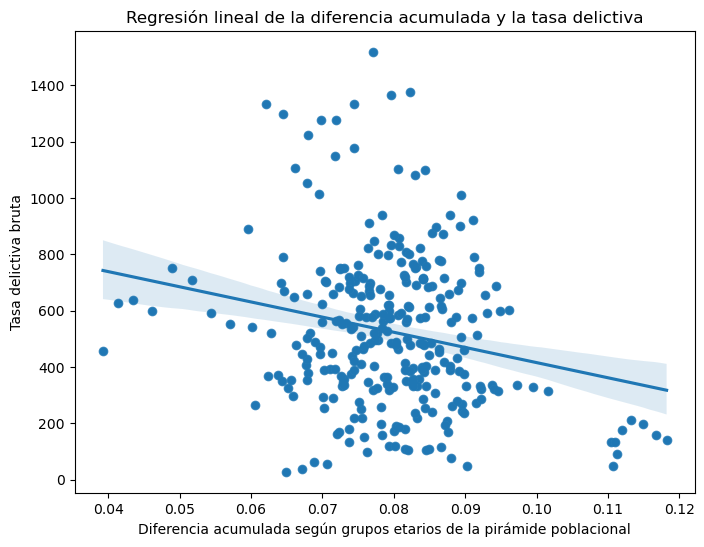

In [47]:

plt.figure(figsize=(8,6))

ax = sns.scatterplot(data = df_tidy_final, x = "CUM_DIFF", y = "TASA_DELICTIVA")
ax = sns.regplot(data = df_tidy_final, x = "CUM_DIFF", y = "TASA_DELICTIVA")
ax.set(title = "Regresión lineal de la diferencia acumulada y la tasa delictiva",
       xlabel = "Diferencia acumulada según grupos etarios de la pirámide poblacional",
       ylabel = "Tasa delictiva bruta"
       )


plt.show()

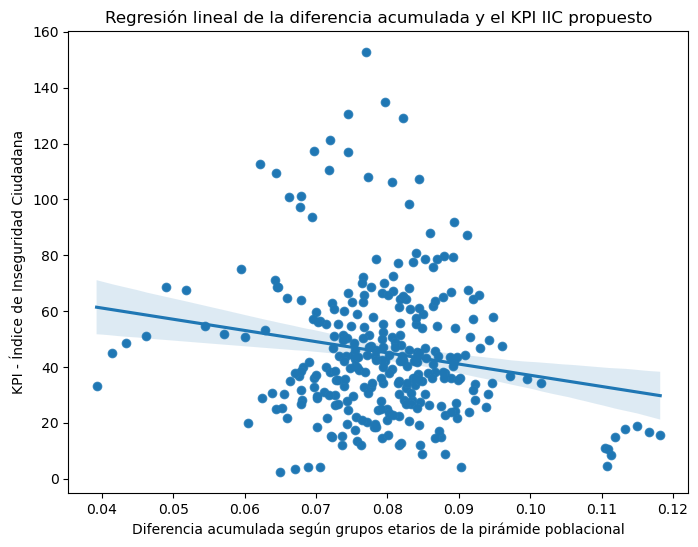

In [48]:
plt.figure(figsize=(8,6))

ax = sns.scatterplot(data = df_tidy_final, x = "CUM_DIFF", y = "KPI_IIC")
ax = sns.regplot(data = df_tidy_final, x = "CUM_DIFF", y = "KPI_IIC")
ax.set(title = "Regresión lineal de la diferencia acumulada y el KPI IIC propuesto",
       xlabel = "Diferencia acumulada según grupos etarios de la pirámide poblacional",
       ylabel = "KPI - Índice de Inseguridad Ciudadana"
       )

plt.show()

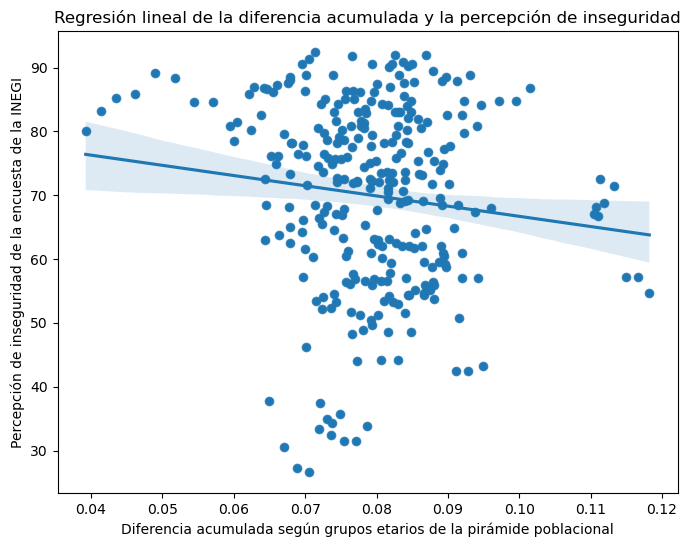

In [49]:
plt.figure(figsize=(8,6))

ax = sns.scatterplot(data = df_tidy_final, x = "CUM_DIFF", y = "PERCEPCION")
ax = sns.regplot(data = df_tidy_final, x = "CUM_DIFF", y = "PERCEPCION")
ax.set(title = "Regresión lineal de la diferencia acumulada y la percepción de inseguridad",
       xlabel = "Diferencia acumulada según grupos etarios de la pirámide poblacional",
       ylabel = "Percepción de inseguridad de la encuesta de la INEGI"
       )

plt.show()

La diferencia acumulada es una suma de las diferencias de las proporciones entre los grupos estarios de la pirámide poblacional y el grupo siguiente, donde al primero se le resta el segundo. Luego se realiza la suma acumulada de estas diferencias. A pesar de que la comprensiónd de las pirámides poblacionales requieren de práctica para su interpretación, el cálculo de parámetros de este tipo no tanto. Entendíendose claramente de que mientras más individuos de menor edad existan en la población, pues mayor será el valor del parámestro calculado.
A simple viste vista durante el EDA se había propuesto la hipótesis de que en las poblaciones con mayor crecimiento, o sea, con mayor nacimiento de niños, podía existir menos actividad delictiva.
Y similares resultados arroja el estudio de este parámetro al compararse en regresiones lineales con la tasa delictiva, el KPI propuesto y la encuesta de percepción de inseguridad de la INEGI. Hallándose que a mayores valores del parámetro se encuentran menores indicadores de inseguridad en la población.

In [50]:
def graficar_kpi_percepcion(entidad):
       df_graf = df_tidy_final[df_tidy_final["ENTIDAD"] == entidad]

       plt.figure(figsize=(8,6))

       ax = sns.scatterplot(data = df_graf, x = "PERCEPCION", y = "KPI_IIC")
       ax = sns.regplot(data = df_graf, x = "PERCEPCION", y = "KPI_IIC")
       ax.set(title = "Regresión lineal del KPI propuesto y la percepción de inseguridad",
              xlabel = "Percepción de inseguridad",
              ylabel = "KPI - Índice de Inseguridad Ciudadana"
              )
       plt.show()
widgets.interact(graficar_kpi_percepcion, entidad = df_tidy_final["ENTIDAD"].unique());

interactive(children=(Dropdown(description='entidad', options=('República Mexicana', 'Aguascalientes', 'Baja C…